https://arxiv.org/abs/1406.0818 
## Step 1: Set up <tt>python</tt> environment

In [1]:
import numpy as np
from scipy import constants
from scipy.optimize import newton
import matplotlib.pylab as plt
import random
% matplotlib inline

# Define constants
year = 365.25 # days in a year
secday = 24. * 3600. # seconds in a day
mearth = 5.9723e24 # Earth's mass in kg
msun = 1.989e30 # Sun's mass in kg
au = 1.496e11 # 1 AU in meters
deg2rad = np.pi / 180.

# Parameters from journal
t_0 = 2452985.74111
mstar = 0.281 #(multiplied by msun in code block 4)
gamma_dot = -0.181  #(ms−1 yr−1)


# kapteyn b
period_b = 48.616 #days
e_b = 0.21
omega_b = 80.4 * deg2rad
M0_b = 269.6 * deg2rad
Msini_b = 4.8 * mearth
offset_b = 0.

# kapteyn c
period_c = 121.54
e_c = 0.23
omega_c = 3.9 * deg2rad
M0_c = 357.6 * deg2rad
Msini_c = 7.0 * mearth
offset_c = 0.

## Step 2: Implement the Murison et al. (2006) method of solving Kepler's equation

In [2]:
# To solve Kepler's equation, make a good starting guess for eccentric anomaly
def KeplerStart3(e, M):
    # Inputs: eccentricity, mean anomaly in RADIANS
    t34 = e**2
    t35 = e*t34
    t33 = np.cos(M)
    return M + (-0.5*t35 + e + (t34 + 1.5*t33*t35)*t33) * np.sin(M)

# 3rd-order method for improving the guess for eccentric anomaly
def eps3(e, M, x):
    # Inputs: eccentricity, mean anomaly in RADIANS, estimate for eccentric anomaly in RADIANS
    t1 = np.cos(x)
    t2 = -1 + e*t1
    t3 = np.sin(x)
    t4 = e*t3
    t5 = -x + t4 + M
    t6 = t5/(0.5*t5*t4/t2 + t2)
    return t5 / ((0.5*t3 - (1./6.)*t1*t6)*e*t6 + t2);

# Solve Kepler's equation (suggested tolerance is 1e-14; Ford (2009) suggests 1e-6 is 
# good enough)
def KeplerSolve(e, M, tol):
    # Inputs: eccentricity, mean anomaly in RADIANS, tolerance
    Mnorm = M % (2*np.pi)
    E0 = KeplerStart3(e, Mnorm)
    dE = tol + 1
    count = 0
    while (dE > tol):
        EE = E0 - eps3(e, Mnorm, E0)
        dE = np.abs(EE - E0)
        E0 = EE
        count += 1
        if (count == 100):
            print("Astounding! KeplerSolve failed to converge!")
            break
    return EE

## Step 3: Function that computes radial velocity based on $e$, $\omega$, $M_0$, and $M \sin(i)$. 
<p>Input parameters to be optimized: eccentricity, argument of periastron, mean anomaly at $t=0$, $M \sin(i)$. The parameters that are required to compute RVs, but will NOT be optimized in the genetic algorithm, and period and star mass.</p>

In [3]:
def rv(inpars, e, omega, M0, Msini, offset):
    # Inputs: inpars is a DICTIONARY of {"Tobs": observation times in SECONDS 
    # shifted so tobs[0] = 0, "Period": period in SECONDS, "Mstar": star mass in KG}. 
    # (The dictionary structure is because we don't want the Keplergram algorithm 
    # to optimize period or Mstar.) 
    # Other inputs are eccentricity, argument of periastron in RADIANS, 
    # mean anomaly at t=0 in RADIANS, planet M sin i in KG, RV offset in M/S
    # tol = 1.0e-14 # tolerance for KeplerSolve
    tobs = inpars["Tobs"]    
    period = inpars["Period"]
    mstar = inpars["Mstar"]
    am = np.cbrt(constants.G * mstar * period**2. / (4.*np.pi**2.)) # semimajor axis in meters
    # Pre-compute factor needed to convert eccentric anomaly to mean anomaly
    efactor = np.sqrt((1.+e)/(1.-e))
    # Turn observation times into mean anomalies
    Mvec = 2.*np.pi*(tobs/period) + M0
    # Find the eccentric anomaly using KeplerSolve, then the true anomaly analytically
    ftrue = np.zeros_like(Mvec)
    for i in range(len(tobs)):
        EE = KeplerSolve(e, Mvec[i], 1.0e-10)
        ftrue[i] = 2. * np.arctan(efactor*np.tan(0.5*EE))
    # Finally, return the radial velocity
    return np.sqrt(constants.G / ((mstar+Msini)*am*(1.-e**2.))) * Msini * \
        (np.cos(omega + ftrue) + e*np.cos(omega)) - offset - gamma_dot*(tobs/(secday*year)) #not sure if this is right

## Load in data and convert to dictionaries

In [4]:
# Input: file of velocity measurements with columns [date, velocity, v error];
dateh, rvh, rverrh = np.loadtxt("dbf_HARPS.txt", unpack=True, usecols=[1,2,3], skiprows=21)
dateH, rvH, rverrH = np.loadtxt("dbf_HIRES.txt", unpack=True, usecols=[1,2,3])

# put the two together
date = np.concatenate((dateh, dateH))
vel = np.concatenate((rvh, rvH))
verr = np.concatenate((rverrh, rverrH))


# Shift the dates so they go from 0 to time baseline
# first = date[0]
sdate = date - t_0

# ensure correct units
mstar *= msun
period_b *= secday
period_c *= secday
# Create the dictionary of non-optimized information for rv()
tinfo_b = {"Tobs": sdate*secday, "Period": period_b, "Mstar": mstar}
tinfo_c = {"Tobs": sdate*secday, "Period": period_c, "Mstar": mstar}

## Call rv function and compute chi^2

chi^2 = 9.313346780457858


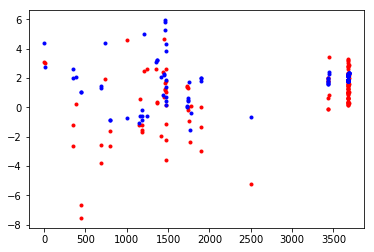

In [5]:
rv_b = rv(tinfo_b, e_b, omega_b, M0_b, Msini_b, offset_b)
rv_c = rv(tinfo_c, e_c, omega_c, M0_c, Msini_c, offset_c)
rv_ = rv_b + rv_c

npars = 11 # e, omega, M0, Msini, period for each planet, plus gamma_dot
N = len(vel)

resid = vel - rv_
s = np.square(resid)/(np.square(verr))
ssum = np.sum(s)
chi = ssum/(N-npars-1)

print("chi^2 =" ,chi)
plt.plot(sdate, vel,'r.') # real rv
plt.plot(sdate, rv_, 'b.') # modeled rv


## Try to recreate figure 2 from journal

(0, 121.54)

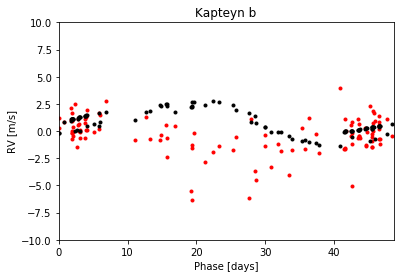

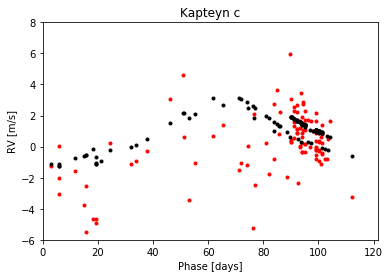

In [6]:
velminusc = vel - rv_c
velminusb = vel - rv_b
dateb = (date%48.616)
datec = (date%121.54)

plt.figure()
plt.plot(dateb, velminusc,'r.')
plt.plot(dateb, rv_b, "k.")
plt.title("Kapteyn b")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-10,10])
plt.xlim([0,48.616])

plt.figure()
plt.plot(datec, velminusb, 'r.')
plt.plot(datec, rv_c, "k.")
plt.title("Kapteyn c")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-6,8])
plt.xlim([0,121.54])

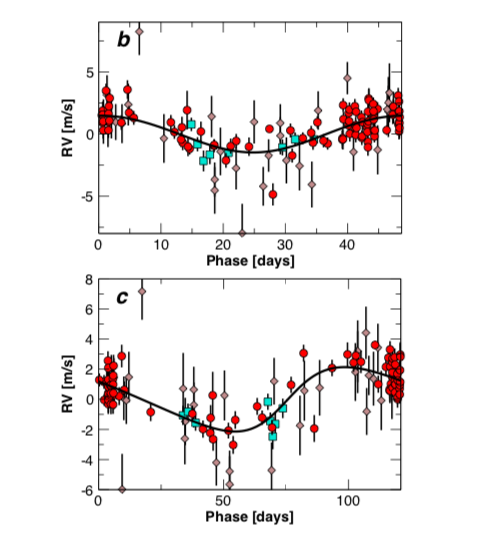

In [7]:
from IPython.display import Image
Image("figure2.png", embed=True)

## Try running the data separately

chi^2 = 9.1266408314017


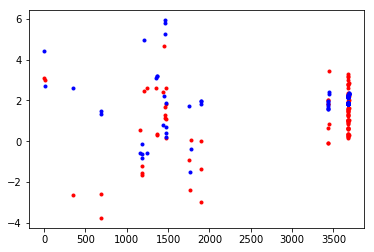

In [8]:
# Shift the dates so they go from 0 to time baseline
sdate = dateh - t_0

# Create the dictionary of non-optimized information for rv()
tinfo_b = {"Tobs": sdate*secday, "Period": period_b, "Mstar": mstar}
tinfo_c = {"Tobs": sdate*secday, "Period": period_c, "Mstar": mstar}

rv_b = rv(tinfo_b, e_b, omega_b, M0_b, Msini_b, offset_b)
rv_c = rv(tinfo_c, e_c, omega_c, M0_c, Msini_c, offset_c)
rv_ = rv_b + rv_c

npars = 4
N = len(rvh)

resid = rvh - rv_
s = np.square(resid)/(np.square(rverrh))
s = np.sum(s)
chi = s/(N-npars-1)

print("chi^2 =" ,chi)
plt.plot(sdate, rvh,'r.')
plt.plot(sdate, rv_, 'b.')

(0, 121.54)

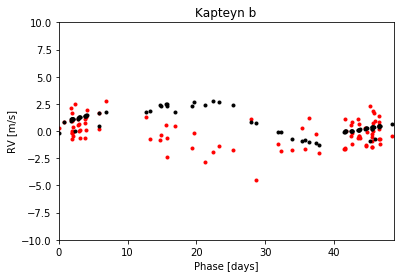

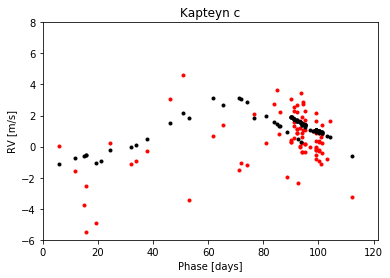

In [9]:
velminusc = rvh - rv_c
velminusb = rvh - rv_b
dateb = (dateh%48.616)
datec = (dateh%121.54)

plt.figure()
plt.plot(dateb, velminusc,'r.')
plt.plot(dateb, rv_b, "k.")
plt.title("Kapteyn b")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-10,10])
plt.xlim([0,48.616])

plt.figure()
plt.plot(datec, velminusb, 'r.')
plt.plot(datec, rv_c, "k.")
plt.title("Kapteyn c")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-6,8])
plt.xlim([0,121.54])

chi^2 = 9.154461714255858


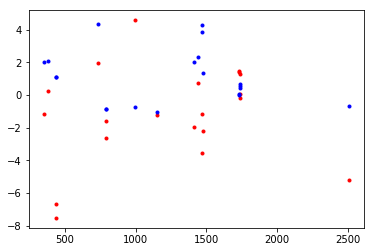

In [10]:
# Shift the dates so they go from 0 to time baseline
first = dateH[0]
sdate = dateH - t_0

# Create the dictionary of non-optimized information for rv()
tinfo_b = {"Tobs": sdate*secday, "Period": period_b, "Mstar": mstar}
tinfo_c = {"Tobs": sdate*secday, "Period": period_c, "Mstar": mstar}

rv_b = rv(tinfo_b, e_b, omega_b, M0_b, Msini_b, offset_b)
rv_c = rv(tinfo_c, e_c, omega_c, M0_c, Msini_c, offset_c)
rv_ = rv_b + rv_c

npars = 4
N = len(rvH)

resid = rvH - rv_
s = np.square(resid)/(np.square(rverrH))
s = np.sum(s)
chi = s/(N-npars-1)

print("chi^2 =" ,chi)
plt.plot(sdate, rvH,'r.')
plt.plot(sdate, rv_, 'b.')

(0, 121.54)

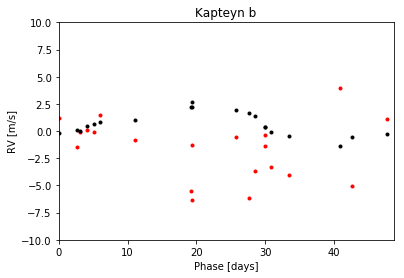

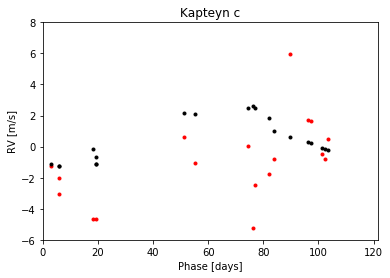

In [11]:
velminusc = rvH - rv_c
velminusb = rvH - rv_b
dateb = (dateH%48.616)
datec = (dateH%121.54)

plt.figure()
plt.plot(dateb, velminusc,'r.')
plt.plot(dateb, rv_b, "k.")
plt.title("Kapteyn b")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-10,10])
plt.xlim([0,48.616])

plt.figure()
plt.plot(datec, velminusb, 'r.')
plt.plot(datec, rv_c, "k.")
plt.title("Kapteyn c")
plt.ylabel("RV [m/s]")
plt.xlabel("Phase [days]")
plt.ylim([-6,8])
plt.xlim([0,121.54])

In [12]:
print(constants.G)

6.67408e-11
